# Lanes & Traffic Sign Project
- Youssef Ayman (211000348)
- Begad Tamim (211002177) 

# Import Nessesary Libraries 

In [7]:
import cv2
import numpy as np
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt

## Useful Functions

In [8]:
def detect_lanes(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to the grayscale image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Perform Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)
    
    # Get the dimensions of the image
    height, width = edges.shape
    
    # Define the region of interest (ROI) vertices
    roi_vertices = np.array([[(0, height), (width / 2, height / 2), (width, height)]], dtype=np.int32)
    
    # Create a mask with the same dimensions as the edges image
    mask = np.zeros_like(edges)
    
    # Fill the ROI in the mask with white color
    cv2.fillPoly(mask, roi_vertices, 255)
    
    # Apply the mask to the edges image
    masked_edges = cv2.bitwise_and(edges, mask)
    
    # Perform Hough Line Transform to detect lines in the masked edges image
    lines = cv2.HoughLinesP(masked_edges, 1, np.pi / 180, threshold=50, minLineLength=100, maxLineGap=50)
    
    # Create a copy of the original image to draw lanes on
    lane_image = np.copy(image)
    
    # Initialize the lane_detected flag as False
    lane_detected = False
    
    # If lines are detected, draw them on the lane_image
    if lines is not None:
        lane_detected = True
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(lane_image, (x1, y1), (x2, y2), (0, 255, 0), 3)
    
    # Return the image with detected lanes and the lane_detected flag
    return lane_image, lane_detected

In [ ]:
def classify_lane_or_curve(lane_detected):
    # Return "Lane" if lane_detected is True, otherwise return "Curve"
    return "Lane" if lane_detected else "Curve"

In [9]:
class TrafficSignDetector:
    def __init__(self, model_path, class_names):
        # Initializes the detection model with the given model path and class names
        self.model = YOLO(model_path)
        self.classes = class_names

    def detect_signs(self, image):
        # Detects traffic signs in the given image using the pre-trained model
        results = self.model(image)
        detected_signs = []
        for result in results:
            for box in result.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                conf = box.conf[0]
                cls = int(box.cls[0])
                if 0 <= cls < len(self.classes):
                    label = f'{self.classes[cls]} {conf:.2f}'
                    detected_signs.append((label, (x1, y1, x2 - x1, y2 - y1)))
                    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        return image, detected_signs


0: 64x128 1 0, 32.6ms
Speed: 5.5ms preprocess, 32.6ms inference, 1.0ms postprocess per image at shape (1, 3, 64, 128)
Image: 08-Traffic-Sign-Recognition-1000x491-1.png
Traffic: Lane
Traffic Sign: [('yield sign 0.70', (809, 124, 65, 77))]


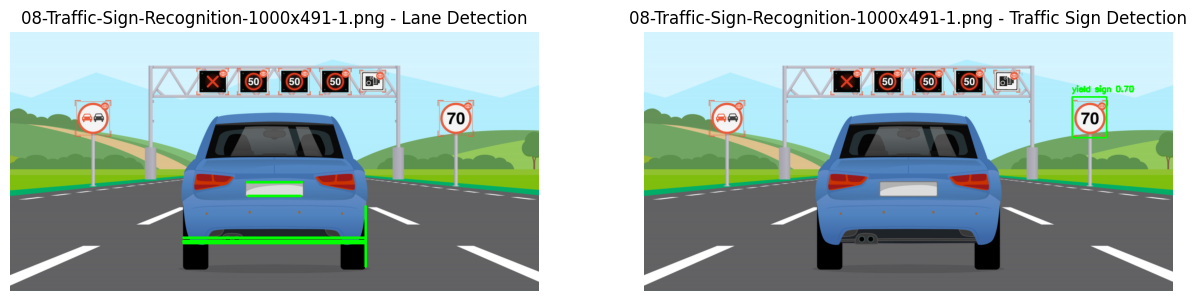


0: 96x128 (no detections), 36.2ms
Speed: 1.0ms preprocess, 36.2ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 128)
Image: Horizontal-curves.jpg
Traffic: Lane
Traffic Sign: []


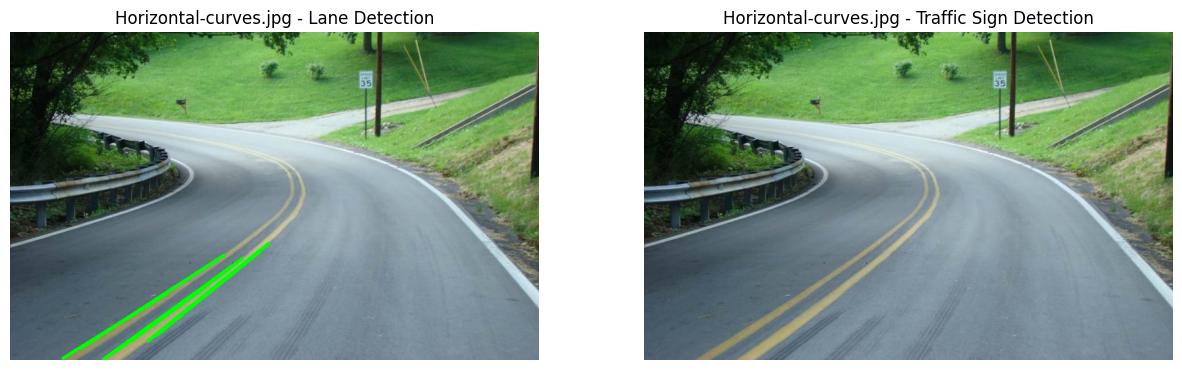


0: 96x128 (no detections), 48.8ms
Speed: 0.0ms preprocess, 48.8ms inference, 1.0ms postprocess per image at shape (1, 3, 96, 128)
Image: images.jpeg
Traffic: Lane
Traffic Sign: []


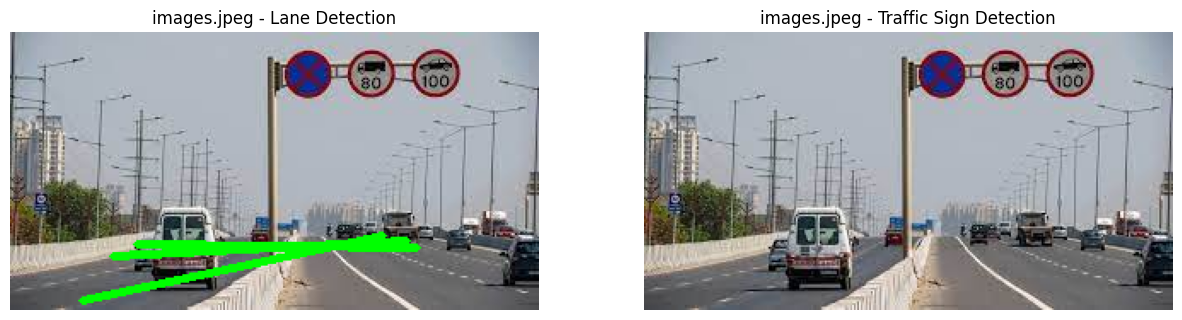


0: 128x128 2 Humps, 46.3ms
Speed: 1.0ms preprocess, 46.3ms inference, 1.5ms postprocess per image at shape (1, 3, 128, 128)
Image: Road-Signs-ezgif.com-resize.png
Traffic: Lane
Traffic Sign: [('no right turn 0.85', (0, 84, 229, 280)), ('no right turn 0.26', (786, 141, 112, 226))]


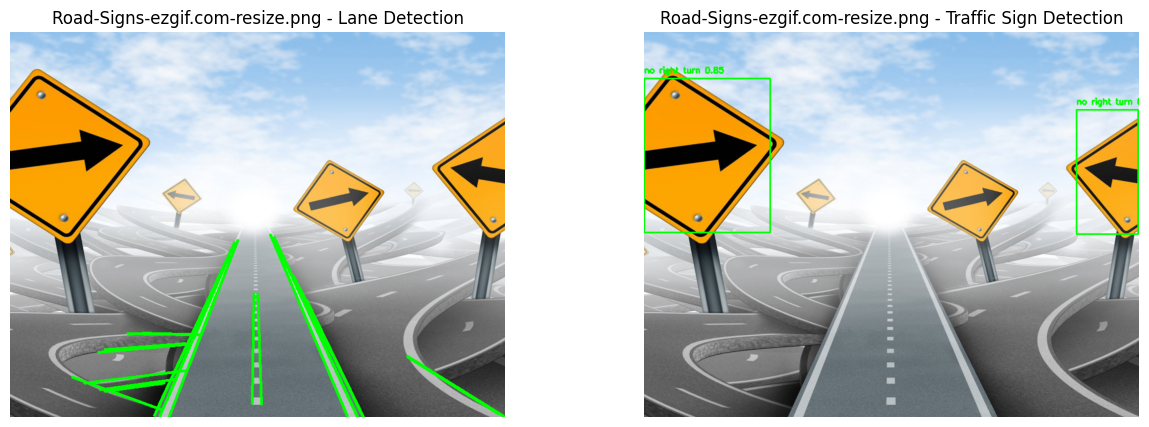


0: 128x128 1 Stop, 38.3ms
Speed: 0.5ms preprocess, 38.3ms inference, 2.5ms postprocess per image at shape (1, 3, 128, 128)
Image: Y1249.png
Traffic: Lane
Traffic Sign: []


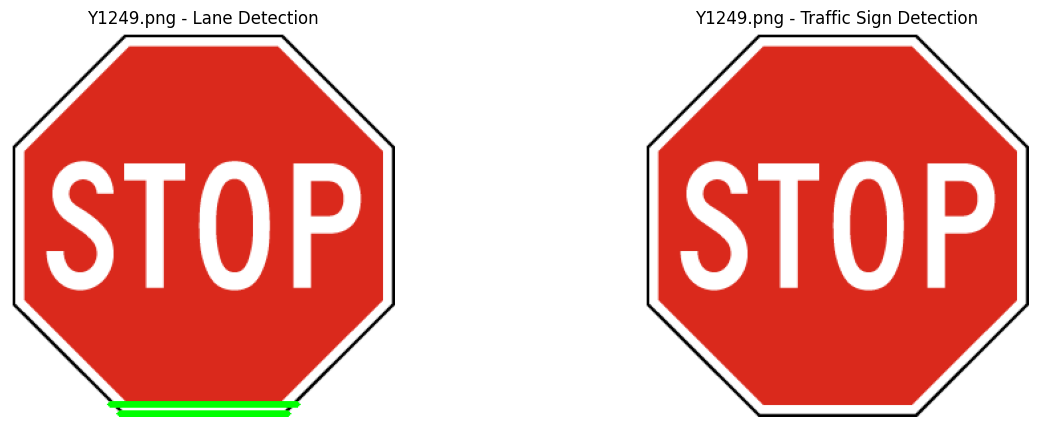

In [10]:
def main():
    
    # Paths and Class Names
    combined_test_dir = r'C:\Users\begad\OneDrive\Term 7\Computer Vision\FInal Project\lane-traffic-sign-detection\data\combined'
    output_dir = r'C:\Users\begad\OneDrive\Term 7\Computer Vision\FInal Project\lane-traffic-sign-detection\output'
    model_path = r'C:\Users\begad\OneDrive\Term 7\Computer Vision\FInal Project\lane-traffic-sign-detection\models\best.pt'
    class_names = [
        'stop sign', 'yield sign', 'speed limit', 'no entry', 'traffic light', 'pedestrian crossing', 'school zone',
        'construction', 'railroad crossing', 'one way', 'do not enter', 'no parking', 'no u-turn', 'no left turn',
        'no right turn', 'roundabout', 'speed bump', 'slippery road', 'animal crossing', 'bicycle lane'
    ]

    detector = TrafficSignDetector(model_path, class_names)

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Process Images
    for image_name in os.listdir(combined_test_dir): # Iterate over each image in the combined test directory
        image_path = os.path.join(combined_test_dir, image_name) # Image Path for each image
        image = cv2.imread(image_path) # Load the image
        if image is None: # Check if the image is loaded successfully
            print(f"Failed to load image {image_path}")
            continue

        # Lane Detection
        lane_image, lane_detected = detect_lanes(image) # Detect lanes in the image
        lane_or_curve = classify_lane_or_curve(lane_detected) # Classify the lane or curve

        # Traffic Sign Detection
        sign_image, most_confident_sign = detector.detect_signs(image.copy()) # Detect traffic signs in the image

        # Output Results
        print(f"Image: {image_name}")
        print(f"Traffic: {lane_or_curve}")
        print(f"Traffic Sign: {most_confident_sign}")

        # Save Results
        lane_output_path = os.path.join(output_dir, f"{image_name}_lane.jpg")
        sign_output_path = os.path.join(output_dir, f"{image_name}_sign.jpg")
        cv2.imwrite(lane_output_path, lane_image)
        cv2.imwrite(sign_output_path, sign_image)

        # Display Results using Matplotlib
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        axs[0].imshow(cv2.cvtColor(lane_image, cv2.COLOR_BGR2RGB))
        axs[0].set_title(f"{image_name} - Lane Detection")
        axs[0].axis('off')
        axs[1].imshow(cv2.cvtColor(sign_image, cv2.COLOR_BGR2RGB))
        axs[1].set_title(f"{image_name} - Traffic Sign Detection")
        axs[1].axis('off')
        plt.show()

    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

In [ ]:
model_path = r'C:\Users\begad\OneDrive\Term 7\Computer Vision\FInal Project\lane-traffic-sign-detection\models\best.pt'
class_names = [
    'speed limit', 'stop sign', 'no entry', 'traffic light', 'pedestrian crossing', 'school zone',
    'construction', 'railroad crossing', 'one way', 'do not enter', 'no parking', 'no u-turn', 'no left turn',
    'no right turn', 'roundabout', 'speed bump', 'slippery road', 'animal crossing', 'bicycle lane'
]

# Initialize the traffic sign detector
detector = TrafficSignDetector(model_path, class_names)

# Open a connection to the webcam
cap = cv2.VideoCapture(0)

while True:
    # Read frame from webcam
    ret, frame = cap.read()
    if not ret:
        break
    
    # Detect lanes in the frame
    lane_image, lane_detected = detect_lanes(frame)
    
    # Classify the lane or curve
    lane_or_curve = classify_lane_or_curve(lane_detected)
    
    # Detect traffic signs in the frame
    sign_image, most_confident_sign = detector.detect_signs(frame)
    
    # Display the lane detection results
    cv2.imshow("Lane Detection", lane_image)
    
    # Display the traffic sign detection results
    cv2.imshow("Traffic Sign Detection", sign_image)
    
    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam
cap.release()

## Conclusion

In this project, we developed a comprehensive system for lane and traffic sign detection using computer vision techniques and deep learning models. The workflow involved several key steps:

1. **Lane Detection**: We implemented a function to detect lanes in images using edge detection and Hough Line Transform. The detected lanes were then classified as either "Lane" or "Curve".

2. **Traffic Sign Detection**: We utilized a pre-trained YOLO model to detect various traffic signs in images. The detected signs were annotated with bounding boxes and class labels.

3. **Integration and Visualization**: We integrated the lane and traffic sign detection functionalities into a main function that processed a set of images, saved the results, and displayed them using Matplotlib.

4. **Real-time Detection**: We extended the system to perform real-time detection using a webcam, allowing for live lane and traffic sign detection.

5. **Utility Functions**: We created utility functions for loading, displaying, and saving images, as well as for resizing images and getting image files from a directory.

6. **Project Structure**: The project is organized into several directories and files, including:
   - `lane_traffic_sign_detection.py`: script for training the lane and traffic sign detection model on 50 epochs.
   - `src/lane_detection.py`: Script for lane detection.
   - `src/traffic_sign_detection.py`: Script for traffic sign detection.
   - `src/utils.py`: Utility functions for image processing.
   - `notebooks/lanes_traffic_signs.ipynb`: Jupyter notebook for running and visualizing the detection algorithms.
   - `requirements.txt`: List of required dependencies.

### Lane Detection (Output)
![Lane Detection](./lane.jpg)

### Traffic Sign Detection(Output)
![Traffic Sign Detection](./sign.jpg)

Overall, this project demonstrates the effectiveness of combining traditional computer vision techniques with deep learning models to achieve robust lane and traffic sign detection. The system can be used for real-time applications, such as autonomous driving, where accurate and timely detection of lanes and traffic signs is crucial.